# Ejercicio análisis time series
Para este ejercicio vas a trabajar con el histórico de valores en bolsa de una empresa que se dedica a vender muebles. Se pide
1. Importa los datos 'df_furniture.csv'
2. Trata la fecha como texto. Crea una columna para el año, mes y dia, y a partir de esas columnas crea la de fecha, en formato datetime de pandas
3. ¿De qué fecha a qué fecha va el histórico?
4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?
5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?
6. Parece que hay una tendencia, pero no se aprecia bien con tanto pico en la serie. ¿Conoces algún método para representar mejor la tendencia?
7. Estaría bien visualizar todos los componentes de la serie temporal por separado
8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional
9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuéstralo mediante una matriz de correlación. ¿Esto es bueno para los modelos?
10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?
11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Cargamos los datos

In [12]:
df = pd.read_csv('data/df_furniture.csv')
df.head()

,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     326 non-null    object 
 1   furniture_price_adjusted  331 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


## 2. Tratar la fecha como texto y parsear

In [49]:
from dateutil.parser import parse
df = pd.read_csv('data/df_furniture.csv', parse_dates = ['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Month                     326 non-null    datetime64[ns]
 1   furniture_price_adjusted  331 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 KB


## 3. ¿De qué fecha a qué fecha va el histórico?

La serie va desde enero de 1992 a julio de 2019

In [11]:
print("La seria va desde", df.Month.min(), "hasta", df.Month.max())

La seria va desde 1992-01-01 00:00:00 hasta 2019-07-01 00:00:00


## 4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?

Se ve que tiene una clara tendencia al alza, a pesar de una pequeña bajada en als acciones en el 2007.

También apreciamos estacionalidad, al cumplirse cierto patrón a lo largo del tiempo

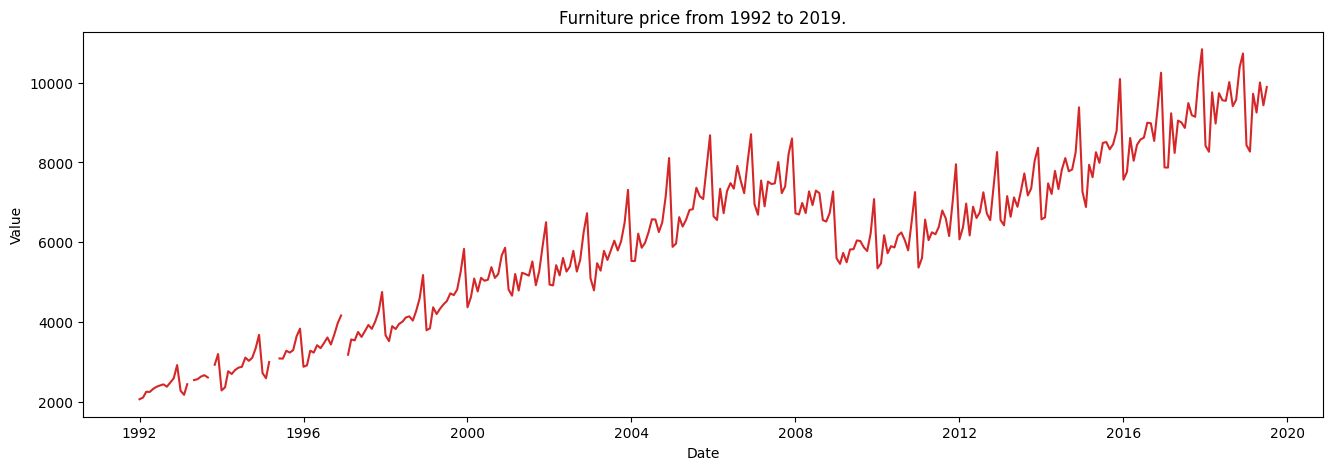

In [16]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.Month, y=df.furniture_price_adjusted, title='Furniture adjusted price from 1992 to 2019.') 

## 5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?

In [18]:
# El primer método para demostrar que la serie no es estacionaria se basa en la Prueba de Dickey-Fuller aumentada
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['furniture_price_adjusted'])
p_value = result[1]

if p_value < 0.05:
    print("La serie temporal es estacionaria")
else:
    print("La serie temporal no es estacionaria")


La serie temporal no es estacionaria


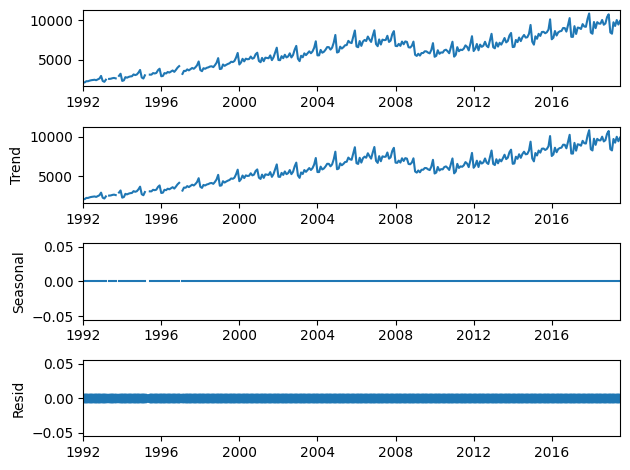

In [56]:
# El segundo método para demostrar que la serie no es estacionaria se basa en la descomposición de la serie temporal
from statsmodels.tsa.seasonal import seasonal_decompose
df['Month'] = pd.to_datetime(df['Month'])
df1 = df.set_index('Month')

result_add = seasonal_decompose(df1, model='additive', extrapolate_trend='freq', period=1)

result_add.plot();

Según este segundo método la serie temporal no es estacional

## 6. ¿Conoces algún método para representar mejor la tendencia?

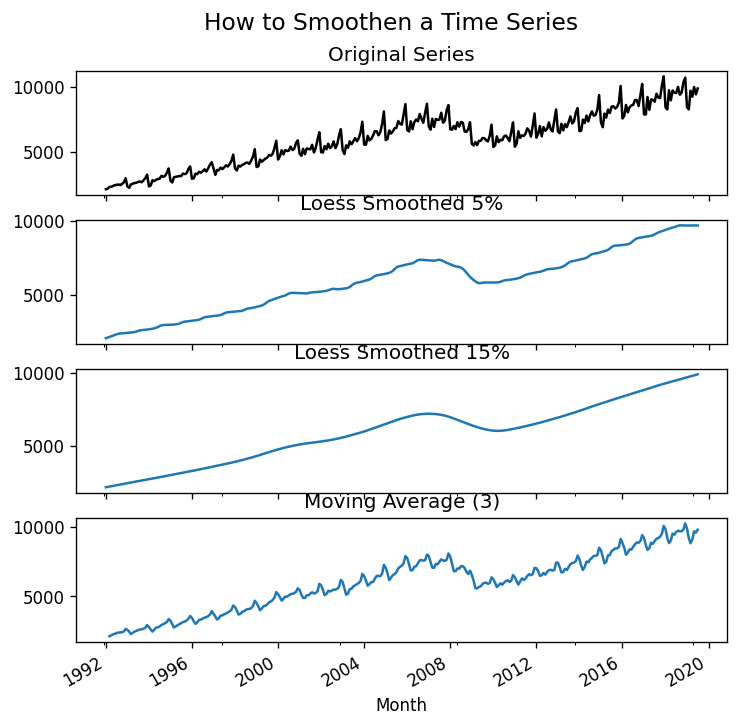

In [58]:
from statsmodels.nonparametric.smoothers_lowess import lowess
# 1. Moving Average
df_ma = df1['furniture_price_adjusted'].rolling(3).mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df1['furniture_price_adjusted'], np.arange(len(df1['furniture_price_adjusted'])), frac=0.05)[:, 1], index=df1.index, columns=['furniture_price_adjusted'])
df_loess_15 = pd.DataFrame(lowess(df1['furniture_price_adjusted'], np.arange(len(df1['furniture_price_adjusted'])), frac=0.15)[:, 1], index=df1.index, columns=['furniture_price_adjusted'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df1['furniture_price_adjusted'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['furniture_price_adjusted'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['furniture_price_adjusted'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

## 7. Estaría bien visualizar todos los componentes de la serie temporal por separado

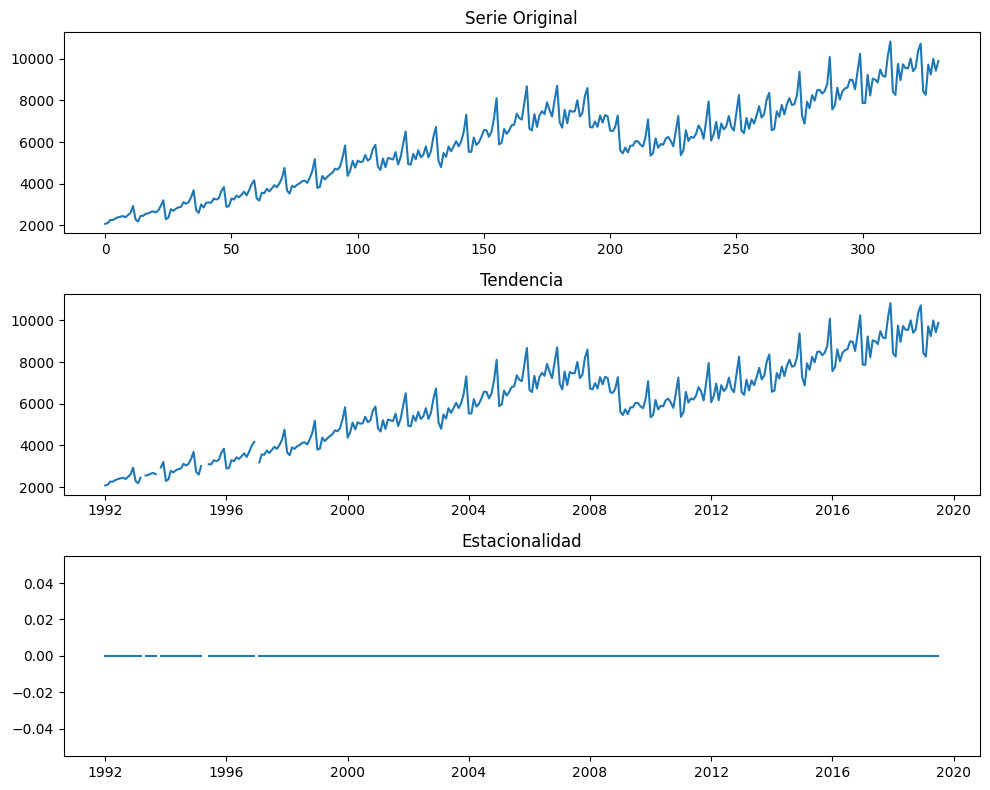

In [62]:
result = seasonal_decompose(df1, model='additive', extrapolate_trend='freq', period=1)

# Obtener los componentes por separado
trend = result.trend
seasonal = result.seasonal

# Crear una figura con subplots para cada componente
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Graficar la serie original
axes[0].plot(df.index, df['furniture_price_adjusted'])
axes[0].set_title('Serie Original')

# Graficar la componente de tendencia
axes[1].plot(trend)
axes[1].set_title('Tendencia')

# Graficar la componente estacional
axes[2].plot(seasonal)
axes[2].set_title('Estacionalidad')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


## 8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional

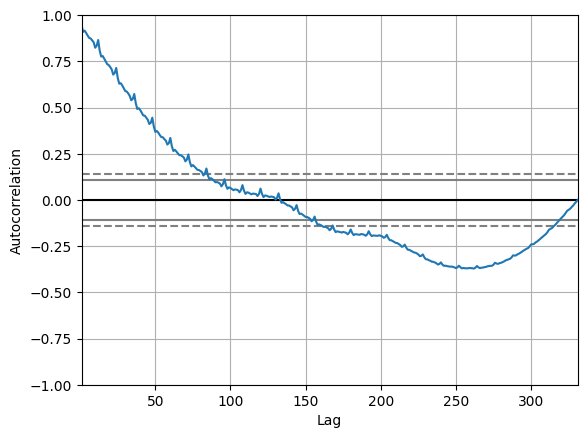

In [63]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['furniture_price_adjusted'].values);

#Los picos no se muestran a intervalos regulares, por lo que no es estacional

## 9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuestralo mediante una matriz de correlación.

In [64]:
lagged_df = pd.DataFrame()

# Usando la función shift de pandas, se desplazan los valores de la serie temporal en cada lag
for i in range(5):
    lagged_df[f'Lag_{i+1}'] = df1['furniture_price_adjusted'].shift(i+1)

# Obtención de la matriz de correlación
correlation_matrix = lagged_df.corr()

# Visualización de la matriz de correlación
print(correlation_matrix)


# Existe una alta correlación entre los lags, obteniendo valores de correlación próximos a 1

          Lag_1     Lag_2     Lag_3     Lag_4     Lag_5
Lag_1  1.000000  0.950599  0.927538  0.944637  0.939980
Lag_2  0.950599  1.000000  0.950224  0.926949  0.944155
Lag_3  0.927538  0.950224  1.000000  0.949927  0.926156
Lag_4  0.944637  0.926949  0.949927  1.000000  0.949554
Lag_5  0.939980  0.944155  0.926156  0.949554  1.000000


## 10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

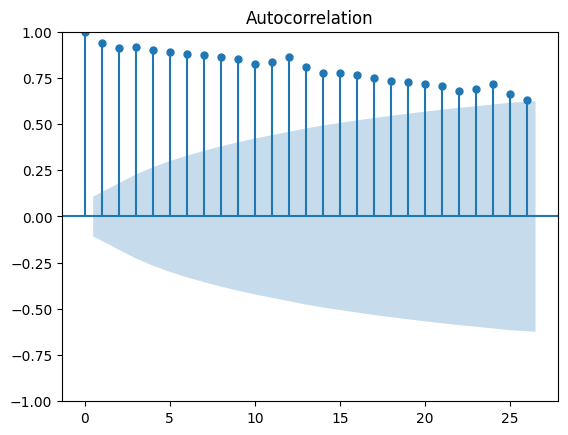

In [71]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df1['furniture_price_adjusted']);

# Parece que el patrón se repite cada 12

## 11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

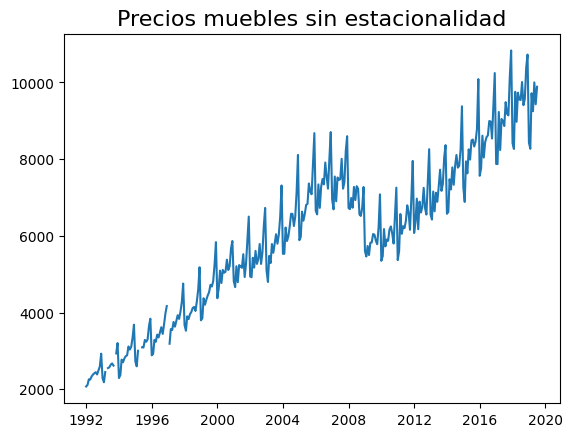

In [73]:
result_add = seasonal_decompose(df1, model='additive', extrapolate_trend='freq', period=1)

# Sin estacionalidad
df_deseasonalized = df1['furniture_price_adjusted'].values - result_add.seasonal

# Plot
plt.plot(df_deseasonalized)
plt.title('Precios muebles sin estacionalidad', fontsize=16);